
<div style="
    background-color: #f7f7f7;
    background-image: url(''), url('') ;
    background-position: left bottom, right top;
    background-repeat: no-repeat,  no-repeat;
    background-size: auto 60px, auto 160px;
    border-radius: 5px;
    box-shadow: 0px 3px 1px -2px rgba(0, 0, 0, 0.2), 0px 2px 2px 0px rgba(0, 0, 0, 0.14), 0px 1px 5px 0px rgba(0,0,0,.12);">

<h1 style="
    color: #2a4cdf;
    font-style: normal;
    font-size: 2.25rem;
    line-height: 1.4em;
    font-weight: 600;
    padding: 30px 200px 0px 30px;"> 
        Perovscribe Evals</h1>

<p style="
    line-height: 1.4em;
    padding: 30px 200px 0px 30px;">
    This notebook runs through the analysis of the Perovscribe extraction pipeline.
</p>

<p style="font-size: 1.25em; font-style: italic; padding: 5px 200px 30px 30px;">
     Sherjeel Shabih, Hampus Näsström, Kevin Jablonka and Pepe Márquez
</p>
</div>

## Setup and Evaluations

### Imports & Setup

In [15]:
# --- Imports ---
import json
import os
from importlib.resources import files
from math import pi
from pathlib import Path

import dabest
import litellm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go

# Third-party libraries
from dotenv import load_dotenv
from litellm.caching import Cache

# Internal modules
# Ensure 'perovscribe' is accessible in the repo structure
from perovscribe.pipeline import ExtractionPipeline
from plotly_theme import register_template, set_defaults

# --- Configuration & Theme ---
load_dotenv()  # Loads .env if present
register_template()
set_defaults()

# Define Paths (Use relative paths for reproducibility!)
DATA_DIR = files("perovscribe").joinpath("data")
EXTRACTIONS_DIR = DATA_DIR / "extractions" 
GROUND_TRUTH_DIR = DATA_DIR / "ground_truth" / "test"
EXPERTS_DIR = EXTRACTIONS_DIR / "humans" / "Consensus"
MODEL_COLORS = {
    "GPT-5 Mini": "#9ecae1",        # light blue
    "GPT-5": "#1f77b4",             # blue
    "GPT-4.1": "#ff7f0e",           # orange
    "GPT-4o": "#ffbb78",            # light orange
    "Claude Sonnet 4": "#2ca02c",   # green
    "Claude Opus 4": "#d62728",     # red
    "Claude Opus 4.1": "#9467bd",   # purple
    "Consensus": "#8c564b"
}


### Optional LLM caching

In [66]:
# Setup Caching
litellm.cache = Cache(
    type="redis",
    host="127.0.0.1",
    port=6379,
    ttl=1000000,
    namespace="litellm",
)

### Model Configurations

In [3]:
# Define model metadata: Display Names, Colors, and Token Costs (per 1M tokens)
# Prices are examples; verify current API pricing.
MODEL_CONFIG = {
    "gpt-5-2025-08-07": {
        "name": "GPT-5",
        "color": "#ff7f0e", # Orange
        "prompt_price": 1.25,
        "output_price": 10.0
    },
    "gpt-5-mini-2025-08-07": {
        "name": "GPT-5 Mini",
        "color": "#1f77b4", # Muted Blue
        "prompt_price": 0.25,
        "output_price": 2.0
    },
    "claude-opus-4-20250514": {
        "name": "Claude Opus 4",
        "color": "#d62728", # Red
        "prompt_price": 15.0,
        "output_price": 75.0
    },
    "claude-sonnet-4-20250514": {
        "name": "Claude Sonnet 4",
        "color": "#9467bd", # Purple
        "prompt_price": 3.0,
        "output_price": 15.0
    },
    "claude-opus-4-1-20250805": {
        "name": "Claude Opus 4.1",
        "color": "#f5a911",
        "prompt_price": 15.0,
        "output_price": 75.0
    },
    "gpt-4.1-2025-04-14": {
        "name": "GPT-4.1",
        "color": "#8c564b", # Brown
        "prompt_price": 2.0,
        "output_price": 8.0
    },
    "gpt-4o-2024-08-06": {
        "name": "GPT-4o",
        "color": "#e377c2", # Pink
        "prompt_price": 2.50,
        "output_price": 10.0
    },
}

## Evaluations

##### Evals Code

In [4]:
# ============================================================================
# DATA LOADING AND MODEL EVALUATION
# ============================================================================

all_metrics = {}  # model_name -> paper_doi -> {field: score}
all_precs_and_recalls = {}

# Evaluate all models
for model_dir in EXTRACTIONS_DIR.iterdir():
    if not model_dir.is_dir() or model_dir == "humans":
        continue
    
    model_name = model_dir.name
    print(f"Evaluating model: {model_name}")
    
    pipeline = ExtractionPipeline(
        model_name=model_name, 
        preprocessor="pymupdf", 
        postprocessor="NONE", 
        cache_dir="", 
        use_cache=True
    )
    model_metrics, avg_recalls, avg_precisions = pipeline._evaluate_multiple(
        model_dir, GROUND_TRUTH_DIR
    )
    
    all_precs_and_recalls[model_name] = {
        "precision": avg_precisions, 
        "recall": avg_recalls
    }
    all_metrics[model_name] = model_metrics

# Rename models to readable names
model_name_map = {
    "claude-opus-4-1-20250805": "Claude Opus 4.1",
    "claude-opus-4-20250514": "Claude Opus 4",
    "claude-sonnet-4-20250514": "Claude Sonnet 4",
    "gpt-4.1-2025-04-14": "GPT-4.1",
    "gpt-4o-2024-08-06": "GPT-4o",
    "gpt-5-2025-08-07": "GPT-5",
    "gpt-5-mini-2025-08-07": "GPT-5 Mini"
}

all_metrics = {
    model_name_map.get(k, k): v for k, v in all_metrics.items()
}

Evaluating model: gpt-4.1-2025-04-14
Error converting 5 wt%: 'wt' is not defined in the unit registry
Error converting 5 wt%: 'wt' is not defined in the unit registry
Error converting 50.0 wt%: 'wt' is not defined in the unit registry
Error converting 50.0 wt%: 'wt' is not defined in the unit registry
Error converting 50.0 wt%: 'wt' is not defined in the unit registry
Error converting 50.0 wt%: 'wt' is not defined in the unit registry
Error converting 50.0 wt%: 'wt' is not defined in the unit registry
Error converting 50.0 wt%: 'wt' is not defined in the unit registry
Error converting 10.0 wt%: 'wt' is not defined in the unit registry
Error converting 10.0 wt%: 'wt' is not defined in the unit registry
Processing file: 10.1039--c5ta00568j.json
LLM judge for perovskite_composition:formula: MAPbI3-xClx vs CH3NH3PbI3 -> True
Mismatch for perovskite_composition:dimensionality: truth='None' vs extraction='3D'
LLM judge for perovskite_composition:a_ions:0:molecular_formula: CH6N+ vs CH5N+ -> 

/home/me/Work/perovskite-extraction/src/perovscribe/pipeline.py:260: RuntimeWarning:

Mean of empty slice

/home/me/Work/perovskite-extraction/src/perovscribe/pipeline.py:261: RuntimeWarning:

Mean of empty slice

/home/me/Work/perovskite-extraction/src/perovscribe/pipeline.py:263: RuntimeWarning:

Mean of empty slice

/home/me/Work/perovskite-extraction/src/perovscribe/pipeline.py:264: RuntimeWarning:

Mean of empty slice



Processing file: 10.1039--c5ta00568j.json
LLM judge for perovskite_composition:formula: MAPbI3-xClx vs CH3NH3PbI3 -> True
Mismatch for perovskite_composition:dimensionality: truth='None' vs extraction='3D'
LLM judge for perovskite_composition:a_ions:0:molecular_formula: CH6N+ vs CH3NH3+ -> True
LLM judge for perovskite_composition:x_ions:0:coefficient: 3-x vs 3 -> False
Mismatch for perovskite_composition:x_ions:0:coefficient: truth='3-x' vs extraction='3'
LLM judge for layers:1:name: TiO2 vs c-TiO2 -> True
LLM judge for layers:2:name: CH3NH3PbI3-xClx  vs CH3NH3PbI3 w/ Al2O3 -> True
Stack: ['FTO', 'TiO2', 'CH3NH3PbI3-xClx ', 'Spiro-OMeTAD', 'Au']
Mismatch for layers:2:deposition:1:step_name: truth='None' vs extraction='NIR annealing'
LLM judge for layers:2:deposition:1:method: NIR annealing vs Thermal-annealing -> False
Stack: ['FTO', 'TiO2', 'CH3NH3PbI3-xClx ', 'Spiro-OMeTAD', 'Au']
Mismatch for layers:2:deposition:1:method: truth='NIR annealing' vs extraction='Thermal-annealing'
LLM 

##### Helper Functions

In [ ]:
# ============================================================================
# HELPER FUNCTIONS (DATAFRAME VERSION)
# ============================================================================

def metrics_to_dataframe(metrics_dict):
    """
    Convert nested metrics dictionary to a flat DataFrame.
    
    Returns:
        DataFrame with columns: model, paper, field, TP, FP, FN
    """
    rows = []
    for model, papers in metrics_dict.items():
        for paper, fields in papers.items():
            for field, values in fields.items():
                if isinstance(values, dict):
                    rows.append({
                        'model': model,
                        'paper': paper,
                        'field': field,
                        'TP': values.get('TP', 0.0),
                        'FP': values.get('FP', 0.0),
                        'FN': values.get('FN', 0.0)
                    })
    return pd.DataFrame(rows)

def add_field_categories(df):
    """Add aggregation category for each field."""
    def categorize(field):  # noqa: PLR0911
        if field.endswith(":unit"):
            return "units"
        field_lower = field.lower()
        if "composition" in field_lower:
            return "composition"
        if "stability" in field_lower:
            return "stability"
        if "deposition" in field_lower:
            return "deposition"
        if "layers" in field_lower:
            return "layers"
        if "light" in field_lower:
            return "light"
        # Clean up individual fields
        if any(x in field for x in ["averaged_quantities", "number_devices", "encapsulated"]):
            return None
        return field.replace("_", " ").split(":value")[0]
    
    df['category'] = df['field'].apply(categorize)
    return df[df['category'].notna()]

def calculate_metrics(df, metric_type='recall'):
    """
    Calculate precision or recall for each row.
    
    Args:
        df: DataFrame with TP, FP, FN columns
        metric_type: 'recall' or 'precision'
    """
    if metric_type == 'recall':
        df['score'] = df.apply(
            lambda row: row['TP'] / (row['TP'] + row['FN']) 
            if (row['TP'] + row['FN']) > 0 else np.nan, 
            axis=1
        )
    else:  # precision
        df['score'] = df.apply(
            lambda row: row['TP'] / (row['TP'] + row['FP']) 
            if (row['TP'] + row['FP']) > 0 else np.nan, 
            axis=1
        )
    return df

## Visualize

#### Overall Performance

##### Code

In [6]:
# ============================================================================
# BAR CHART: OVERALL MODEL PERFORMANCE (DATAFRAME VERSION)
# ============================================================================

# Calculate overall metrics per model
df = metrics_to_dataframe(all_metrics)

df_doi = df.groupby(['model', 'paper']).agg({'TP':'sum', 'FP':'sum', 'FN':'sum'}).reset_index()

overall = df_doi.groupby('model').sum().reset_index()
overall['precision'] = overall['TP'] / (overall['TP'] + overall['FP'])
overall['recall']    = overall['TP'] / (overall['TP'] + overall['FN'])


# Plot
x = np.arange(len(overall))
width = 0.35

overall_performance_fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, overall['precision'], width, 
                label='Precision', color='skyblue')
rects2 = ax.bar(x + width/2, overall['recall'], width, 
                label='Recall', color='salmon')

ax.set_ylabel('Score', fontsize=22)
ax.set_title('Model Performances', fontsize=40, pad=50)
ax.set_xticks(x)
ax.set_xticklabels(overall['model'], rotation=45, fontsize=18)
ax.set_yticks(np.arange(0, 1.1, 0.4))
ax.set_yticklabels([f"{y:.1f}" for y in np.arange(0, 1.1, 0.4)], fontsize=16)
ax.set_ylim(0, 1.05)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), 
          ncol=2, fontsize=28, frameon=False)

# Add value labels
for rects, values in [(rects1, overall['precision']), (rects2, overall['recall'])]:
    for rect, val in zip(rects, values):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height + 0.02,
                f'{val:.2f}', ha='center', va='bottom', fontsize=16)
plt.tight_layout()
plt.close(overall_performance_fig)   # <-- prevents display in this cell

##### Plot

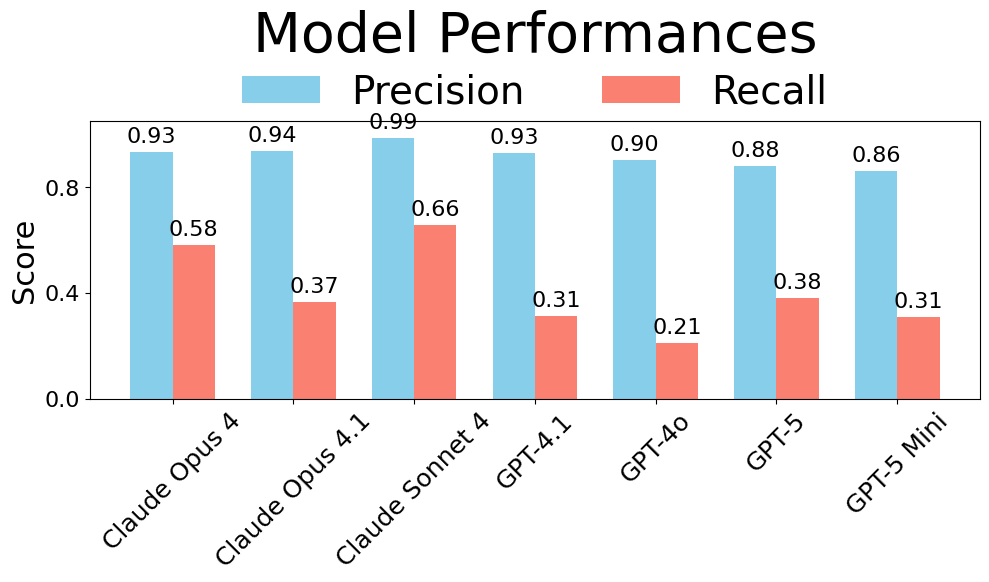

In [7]:
overall_performance_fig

#### Radar Plot: Recalls per field

##### Code

In [8]:
# ============================================================================
# RADAR PLOT: MODEL RECALLS PER FIELD (DATAFRAME VERSION)
# ============================================================================

# Convert to DataFrame and calculate recalls
df = metrics_to_dataframe(all_metrics)
df = add_field_categories(df)
df = calculate_metrics(df, metric_type='recall')

# Aggregate by model and category
aggregated = df.groupby(['model', 'category'])['score'].mean().reset_index()

# Pivot for radar plot
pivot_df = aggregated.pivot(index='model', columns='category', values='score').fillna(0)

# Create radar plot
fields = sorted(pivot_df.columns)
num_fields = len(fields)
angles = [n / float(num_fields) * 2 * pi for n in range(num_fields)]
angles += angles[:1]

radar_recall_fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(111, polar=True)

# Plot each model
for model_name in pivot_df.index:
    scores = pivot_df.loc[model_name, fields].tolist()
    values = scores + [scores[0]]

    color = MODEL_COLORS.get(model_name, "#333333")  # fallback if missing

    ax.plot(
        angles,
        values,
        label=model_name,
        linewidth=2,
        color=color,
    )
    ax.fill(
        angles,
        values,
        color=color,
        alpha=0.03,
    )


# [Rest of plotting code remains the same...]
ax.set_ylim(0.0, 1)
angle_degrees = [a * 180 / np.pi for a in angles[:-1]]
ax.set_thetagrids(angle_degrees, labels=fields)
ax.tick_params(axis='x', pad=25)

for label in ax.get_xticklabels():
    label.set_fontsize(24)
    label.set_color("dimgray")
    label.set_rotation(45)
    label.set_horizontalalignment("center")

ax.set_yticks(np.linspace(0.0, 1, 3))
ax.set_yticklabels([f"{y:.1f}" for y in np.linspace(0.0, 1, 3)], 
                    fontsize=24, color="dimgray")

ax.set_theta_offset(np.deg2rad(17))
ax.set_theta_direction(-1)

plt.title("Model Recalls per Field", size=40, color="dimgray")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), 
           fontsize=24, ncol=2, frameon=False)
plt.tight_layout()
plt.close(radar_recall_fig)

##### Recall Plot

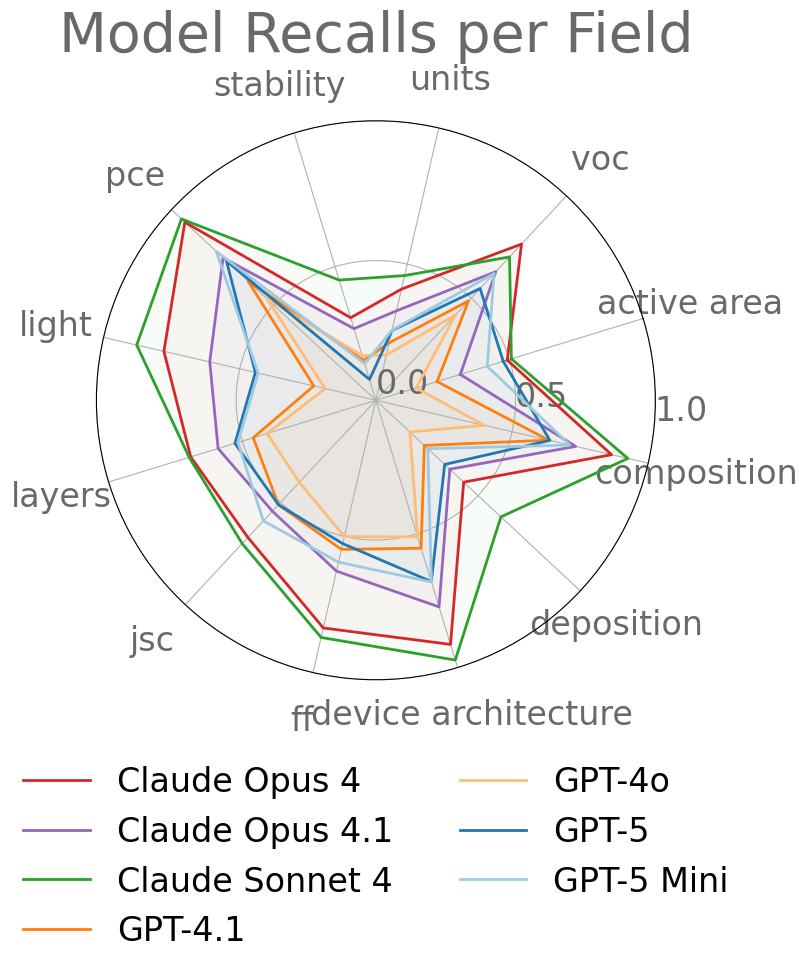

In [9]:
radar_recall_fig

#### Radar Plot: Precisions per field

##### Code

In [10]:
# ============================================================================
# RADAR PLOT: MODEL PRECISIONS PER FIELD (DATAFRAME VERSION)
# ============================================================================

# Convert to DataFrame and calculate precisions
df = metrics_to_dataframe(all_metrics)
df = add_field_categories(df)
df = calculate_metrics(df, metric_type='precision')  # Changed to precision

# Aggregate by model and category
aggregated = df.groupby(['model', 'category'])['score'].mean().reset_index()

# Pivot for radar plot
pivot_df = aggregated.pivot(index='model', columns='category', values='score').fillna(0)

# Create radar plot
fields = sorted(pivot_df.columns)
num_fields = len(fields)
angles = [n / float(num_fields) * 2 * pi for n in range(num_fields)]
angles += angles[:1]

radar_precision_fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(111, polar=True)

# Plot each model
for model_name in pivot_df.index:
    scores = pivot_df.loc[model_name, fields].tolist()
    values = scores + [scores[0]]

    color = MODEL_COLORS.get(model_name, "#333333")  # fallback if missing

    ax.plot(
        angles,
        values,
        label=model_name,
        linewidth=2,
        color=color,
    )
    ax.fill(
        angles,
        values,
        color=color,
        alpha=0.03,
    )


# Customize plot
ax.set_ylim(0.3, 1)  # Different y-limit for precisions
angle_degrees = [a * 180 / np.pi for a in angles[:-1]]
ax.set_thetagrids(angle_degrees, labels=fields)
ax.tick_params(axis='x', pad=25)

# Style field labels
for label in ax.get_xticklabels():
    label.set_fontsize(24)
    label.set_color("dimgray")
    label.set_rotation(45)
    label.set_horizontalalignment("center")

# Style radial ticks
ax.set_yticks(np.linspace(0.3, 1, 3))
ax.set_yticklabels([f"{y:.1f}" for y in np.linspace(0.3, 1, 3)], 
                    fontsize=24, color="dimgray")

# Rotate plot
ax.set_theta_offset(np.deg2rad(17))
ax.set_theta_direction(-1)

# Title and legend
plt.title("Model Precisions per Field", size=40, color="dimgray")
plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.1),
    fontsize=24,
    ncol=2,
    frameon=False
)

plt.tight_layout()
plt.close(radar_precision_fig)
# plt.savefig("plots/model_precisions_spider.pdf")

##### Plot

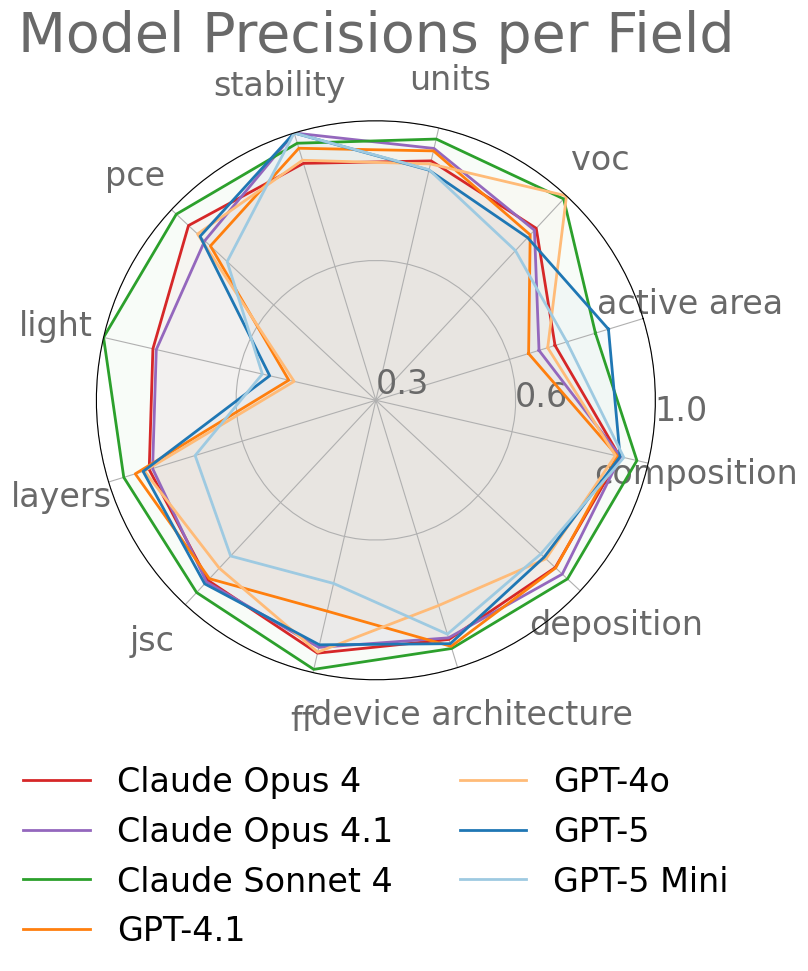

In [11]:
radar_precision_fig

### Visualize: Cost vs Performance

##### Code

In [16]:
# ============================================================================
# PLOTLY: MODEL PERFORMANCE VS COST
# ============================================================================

# Token usage and pricing data
tokens_used = {
    "GPT-5 Mini": {
        "Prompt Tokens": 883572,
        "Completion Tokens": 258233,
        "prompt_price": 0.250,
        "output_price": 2.0
    },
    "GPT-5": {
        "Prompt Tokens": 750932,
        "Completion Tokens": 260215,
        "prompt_price": 1.250,
        "output_price": 10.0
    },
    "Claude Opus 4.1": {
        "Prompt Tokens": 695811,
        "Completion Tokens": 128001,
        "prompt_price": 15.0,
        "output_price": 75.0
    },
    "Claude Opus 4": {
        "Prompt Tokens": 1000308,
        "Completion Tokens": 230768,
        "prompt_price": 15.0,
        "output_price": 75.0
    },
    "Claude Sonnet 4": {
        "Prompt Tokens": 889990,
        "Completion Tokens": 174639,
        "prompt_price": 3.0,
        "output_price": 15.0
    },
    "GPT-4.1": {
        "Prompt Tokens": 750680,
        "Completion Tokens": 54524,
        "prompt_price": 2.0,
        "output_price": 8.0
    },
    "GPT-4o": {
        "Prompt Tokens": 677364,
        "Completion Tokens": 28682,
        "prompt_price": 2.50,
        "output_price": 10.0
    },
}

# Calculate costs and merge with performance metrics
cost_data = []
for model, tokens in tokens_used.items():
    prompt_tokens = tokens["Prompt Tokens"]
    completion_tokens = tokens["Completion Tokens"]
    prompt_price = tokens["prompt_price"]
    output_price = tokens["output_price"]
    total_cost = (prompt_tokens / 1_000_000) * prompt_price + (completion_tokens / 1_000_000) * output_price
    
    cost_data.append({
        "model": model,
        "cost": round(total_cost, 4)
    })

# Create cost DataFrame
df_cost = pd.DataFrame(cost_data)

# Merge with the overall performance metrics (from the bar chart section)
# Assuming 'overall' DataFrame exists from the previous bar chart code
df_plot = overall.merge(df_cost, on='model', how='inner')

# Calculate F1 score
df_plot['f1'] = (2 * df_plot['precision'] * df_plot['recall']) / (df_plot['precision'] + df_plot['recall'])
df_plot = df_plot.dropna(subset=['f1'])

# Create Plotly figure
perf_cost_fig = go.Figure()

for index, row in df_plot.iterrows():
    model = row['model']
    cost = row['cost']
    f1 = row['f1']
    
    color = MODEL_COLORS.get(model, "#333333")

    # Scatter trace for marker
    perf_cost_fig.add_trace(
        go.Scatter(
            x=[cost],
            y=[f1],
            mode='markers',
            name=model, 
            marker=dict(
                size=15,
                opacity=0.8,
                color=color
            ),
            hovertemplate='<b>%{text}</b><br>Cost: $%{x:.4f}<br>F1 Score: %{y:.4f}<extra></extra>',
            text=[model]
        )
    )

    # Text trace for label
    perf_cost_fig.add_trace(
        go.Scatter(
            x=[cost],
            y=[f1-0.014],
            mode='text',
            name=model + ' Label', 
            text=[model],
            textposition='bottom center',
            showlegend=False,
            textfont=dict(size=14, color=color),
            hoverinfo='none'
        )
    )

# Layout
perf_cost_fig.update_layout(
    title={
        'text': "Model Performance vs Cost",
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title="Total Cost (USD)",
    yaxis_title="F1 Score",
    showlegend=True,
    legend=dict(
        orientation="v",
        yanchor="middle",
        y=0.5,
        xanchor="left",
        x=1.02,
        bgcolor="rgba(255, 255, 255, 0.5)",
        bordercolor="Black",
        borderwidth=1
    )
)

perf_cost_fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='rgba(128,128,128,0.5)')
perf_cost_fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='rgba(128,128,128,0.5)')

pass

##### Plot

In [17]:
perf_cost_fig.show()

### Comparison with Experts

#### Evaluation Code

In [67]:
pipeline = ExtractionPipeline(model_name="Consensus", preprocessor="pymupdf", postprocessor="NONE", cache_dir="", use_cache=True)
authors_metrics, authors_recalls, authors_precisions = pipeline._evaluate_multiple(EXPERTS_DIR, GROUND_TRUTH_DIR)

Error converting 5 wt%: 'wt' is not defined in the unit registry
Error converting 5 wt%: 'wt' is not defined in the unit registry
[Errno 2] No such file or directory: '/home/me/Work/perovskite-extraction/src/perovscribe/data/extractions/humans/Consensus/10.1038--s41467-021-27740-4.json'
[Errno 2] No such file or directory: '/home/me/Work/perovskite-extraction/src/perovscribe/data/extractions/humans/Consensus/10.1002--solr.202300817.json'
[Errno 2] No such file or directory: '/home/me/Work/perovskite-extraction/src/perovscribe/data/extractions/humans/Consensus/10.1126--science.adf0194.json'
[Errno 2] No such file or directory: '/home/me/Work/perovskite-extraction/src/perovscribe/data/extractions/humans/Consensus/10.1021--acsaelm.4c02297.json'
[Errno 2] No such file or directory: '/home/me/Work/perovskite-extraction/src/perovscribe/data/extractions/humans/Consensus/10.1038--s41467-023-36141-8.json'
[Errno 2] No such file or directory: '/home/me/Work/perovskite-extraction/src/perovscribe/

In [68]:
all_metrics["Consensus"] = authors_metrics
experts_included_df = metrics_to_dataframe(all_metrics)

# 1. Get the set of papers that appear with model == "Consensus"
expert_papers = set(experts_included_df.loc[
    experts_included_df["model"] == "Consensus", 
    "paper"
])

# 2. Filter the DataFrame
filtered_df = experts_included_df[
    (experts_included_df["model"] == "Consensus") |
    ((experts_included_df["model"] != "Consensus") &
     (experts_included_df["paper"].isin(expert_papers)))
]

In [69]:
# Group by paper and model, sum TP and FP
micro_precision_df = (
    filtered_df
    .groupby(['paper', 'model'])
    [['TP', 'FP']]
    .sum()
    .reset_index()
)

# Compute micro-precision
micro_precision_df['precision'] = micro_precision_df['TP'] / (micro_precision_df['TP'] + micro_precision_df['FP'])


In [70]:
# Only select the papers where both LLMs and experts exist
papers_with_both = micro_precision_df['paper'].value_counts()
papers_with_both = papers_with_both[papers_with_both > 1].index
df_plot = micro_precision_df[micro_precision_df['paper'].isin(papers_with_both)]

# Pivot data so each row is a DOI and each column is a model
df_pivot = df_plot.pivot(index='paper', columns='model', values='precision').reset_index()

# Melt data for dabest
df_melt = df_pivot.melt(id_vars='paper', var_name='model', value_name='precision')

# Create a dabest object using authors as the control
dabest_data = dabest.load(
    data=df_melt,
    x='model',
    y='precision',
    idx=("Consensus", "GPT-4.1", "Claude Opus 4", "GPT-4o", "GPT-5",
         "Claude Sonnet 4", "Claude Opus 4.1", "GPT-5 Mini")
)

# Plot mean difference against authors
plt.figure(figsize=(10,6))
mean_fig = dabest_data.mean_diff.plot(
    raw_marker_size=4,
    custom_palette=MODEL_COLORS,  # <-- this is the key line
)

plt.close(mean_fig)

<Figure size 1000x600 with 0 Axes>

#### Mean Difference per paper

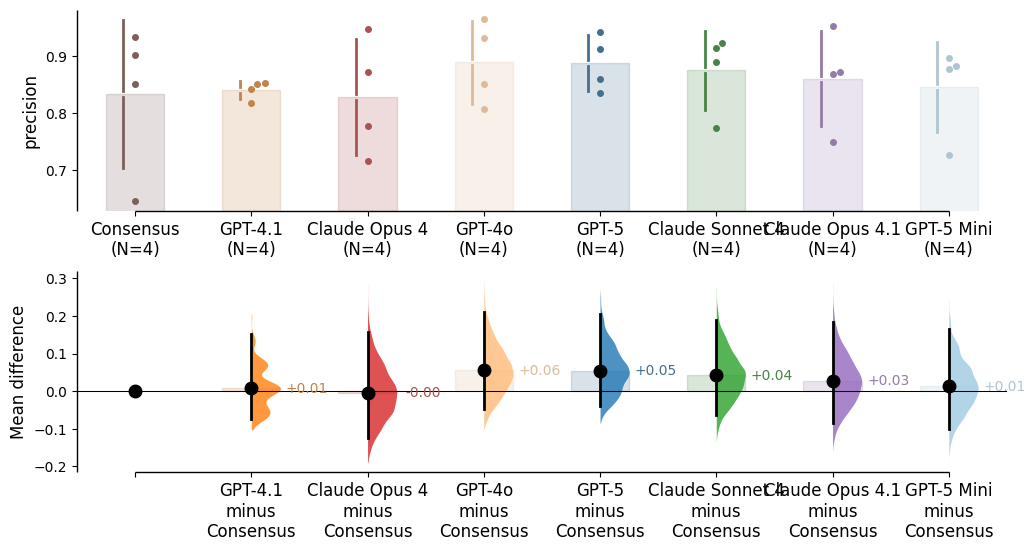

In [72]:
mean_fig

#### Overlapping extractions spider plots

In [ ]:
# ============================================================================
# DATA LOADING AND MODEL EVALUATION
# ============================================================================

human_metrics = {}  # model_name -> paper_doi -> {field: score}
human_precs_and_recalls = {}

HUMANS_DIR = EXTRACTIONS_DIR / "humans"
DEV_DIR = DATA_DIR / "ground_truth" / "dev"
# Evaluate all models
for model_dir in HUMANS_DIR.iterdir():
    if not model_dir.is_dir():
        continue
    
    model_name = model_dir.name
    print(f"Evaluating model: {model_name}")
    
    pipeline = ExtractionPipeline(
        model_name=model_name, 
        preprocessor="pymupdf", 
        postprocessor="NONE", 
        cache_dir="", 
        use_cache=True
    )
    model_metrics, avg_recalls, avg_precisions = pipeline._evaluate_multiple(
        model_dir, DEV_DIR
    )
    
    human_precs_and_recalls[model_name] = {
        "precision": avg_precisions, 
        "recall": avg_recalls
    }
    human_metrics[model_name] = model_metrics

sonnet_4_metrics, s_rec, s_prec = pipeline._evaluate_multiple(
    EXTRACTIONS_DIR / "claude-sonnet-4-20250514/",
    DEV_DIR
)
human_metrics["Claude Sonnet 4"] = sonnet_4_metrics

Evaluating model: Consensus
Error converting 35.0 wt%: 'wt' is not defined in the unit registry
Error converting 35.0 wt%: 'wt' is not defined in the unit registry
Error converting 22 wt%: 'wt' is not defined in the unit registry
Error converting 22 wt%: 'wt' is not defined in the unit registry
Error converting 22 wt%: 'wt' is not defined in the unit registry
Error converting 22 wt%: 'wt' is not defined in the unit registry
Error converting 22 wt%: 'wt' is not defined in the unit registry
Error converting 14.3 wt%: 'wt' is not defined in the unit registry
Error converting 14.3 wt%: 'wt' is not defined in the unit registry
Error converting 14.3 wt%: 'wt' is not defined in the unit registry
Error converting 14.3 wt%: 'wt' is not defined in the unit registry
Processing file: 10.1016--j.nanoen.2016.05.023.json
LLM judge for layers:1:deposition:0:atmosphere: Ambient Air vs Air -> True
LLM judge for layers:2:deposition:0:atmosphere: Ambient Air vs Air -> True
LLM judge for layers:3:depositio

##### What dois match across our extractions

In [76]:
from collections import defaultdict

doi_to_groups = defaultdict(list)

for group, dois in human_metrics.items():
    for doi in dois:
        doi_to_groups[doi].append(group)

print("DOI matches across groups:\n")
for doi, groups in doi_to_groups.items():
    if len(groups) > 1:
        print(f"{doi} -> {', '.join(groups)}")

DOI matches across groups:

10.1016--j.nanoen.2016.05.023.json -> Consensus, Bear, Lark, Dove, Seal, Panda, Hawk, Claude Sonnet 4
10.1016--j.matlet.2016.07.004.json -> Consensus, Bear, Lark, Dove, Claude Sonnet 4
10.1039--c5dt02388b.json -> Consensus, Otto, Bear, Kit, Claude Sonnet 4
10.1002--solr.201900370.json -> Consensus, Bear, Kit, Lark, Claude Sonnet 4
10.1002--adfm.201500335.json -> Consensus, Dove, Bee, Panda, Claude Sonnet 4
10.1039--c7nr04692h.json -> Consensus, Bear, Kit, Dove, Claude Sonnet 4
10.1021--acsaem.9b01928.json -> Consensus, Dove, Seal, Bee, Panda, Claude Sonnet 4
10.1002--adma.202302143.json -> Consensus, Robin, Bee, Claude Sonnet 4
10.1021--acs.chemmater.8b01521.json -> Consensus, Kit, Robin, Seal, Claude Sonnet 4
10.1002--adfm.201904856.json -> Consensus, Fox, Kit, Bee, Claude Sonnet 4


##### Code

In [ ]:
# ============================================================================
# RADAR PLOT: MODEL PRECISIONS PER FIELD (DATAFRAME VERSION)
# ============================================================================
from matplotlib.lines import Line2D

# Convert to DataFrame and calculate precisions
df = metrics_to_dataframe(human_metrics)
df = add_field_categories(df)
df = calculate_metrics(df, metric_type='precision')  # Changed to precision

# Aggregate by model and category
aggregated = df.groupby(['model', 'category'])['score'].mean().reset_index()

# Pivot for radar plot
pivot_df = aggregated.pivot(index='model', columns='category', values='score').fillna(0)

# Create radar plot
fields = sorted(pivot_df.columns)
num_fields = len(fields)
angles = [n / float(num_fields) * 2 * pi for n in range(num_fields)]
angles += angles[:1]

human_radar_precision_fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(111, polar=True)

# Plot each model
for model_name in pivot_df.index:
    scores = pivot_df.loc[model_name, fields].tolist()
    values = scores + [scores[0]]
    
    # 2. Set distinct color for the line
    line_color = MODEL_COLORS.get(model_name, "#333333")
    
    # 3. Control visibility and emphasis
    if model_name in ('Consensus', 'Claude Sonnet 4'):
        # Highlight: Bright color, thicker line, higher alpha fill
        line_alpha = 1.0  # Full opacity for the line
        fill_alpha = 0.2  # Moderate fill opacity
        line_width = 4    # Thicker line
    else:
        # Dimmer: Lower opacity for line and fill, normal line width
        line_alpha = 0.3  # Dimmed opacity
        fill_alpha = 0.02 # Very light fill
        line_width = 2    # Normal line width
        line_color = "gray"

    line, = ax.plot(
        angles, 
        values, 
        label=model_name, 
        linewidth=line_width,
        color=line_color,  # Apply the unique color
        alpha=line_alpha   # Apply the line opacity
    )
    
    ax.fill(
        angles, 
        values, 
        color=line_color,  # Apply the unique color
        alpha=fill_alpha   # Apply the fill opacity
    )

# Customize plot (Rest of the customization remains the same)
ax.set_ylim(0.3, 1)  # Different y-limit for precisions
angle_degrees = [a * 180 / np.pi for a in angles[:-1]]
ax.set_thetagrids(angle_degrees, labels=fields)
ax.tick_params(axis='x', pad=25)

# Style field labels
for label in ax.get_xticklabels():
    label.set_fontsize(24)
    label.set_color("dimgray")
    label.set_rotation(45)
    label.set_horizontalalignment("center")

# Style radial ticks
ax.set_yticks(np.linspace(0.3, 1, 3))
ax.set_yticklabels([f"{y:.1f}" for y in np.linspace(0.3, 1, 3)], 
                    fontsize=24, color="dimgray")

# Rotate plot
ax.set_theta_offset(np.deg2rad(17))
ax.set_theta_direction(-1)

# Title and legend
plt.title("Model Precisions per Field", size=40, color="dimgray")
humans_legend_handle = Line2D(
    [0], [0],
    color="gray",
    linewidth=4,
    alpha=1.0,
    label="Humans"
)
# Get existing handles (Consensus & Sonnet 4 only)
handles, labels = ax.get_legend_handles_labels()

allowed = {"Consensus", "Claude Sonnet 4"}
filtered = [(allowed_handle, allowed_label) for allowed_handle, allowed_label in zip(handles, labels) if allowed_label in allowed]
handles, labels = zip(*filtered)

# Add Humans as legend-only entry
handles = list(handles) + [humans_legend_handle]
labels = list(labels) + ["Humans"]

plt.legend(
    handles,
    labels,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.1),
    fontsize=24,
    ncol=3,
    frameon=False
)
plt.tight_layout()
plt.close(human_radar_precision_fig)

##### Plot

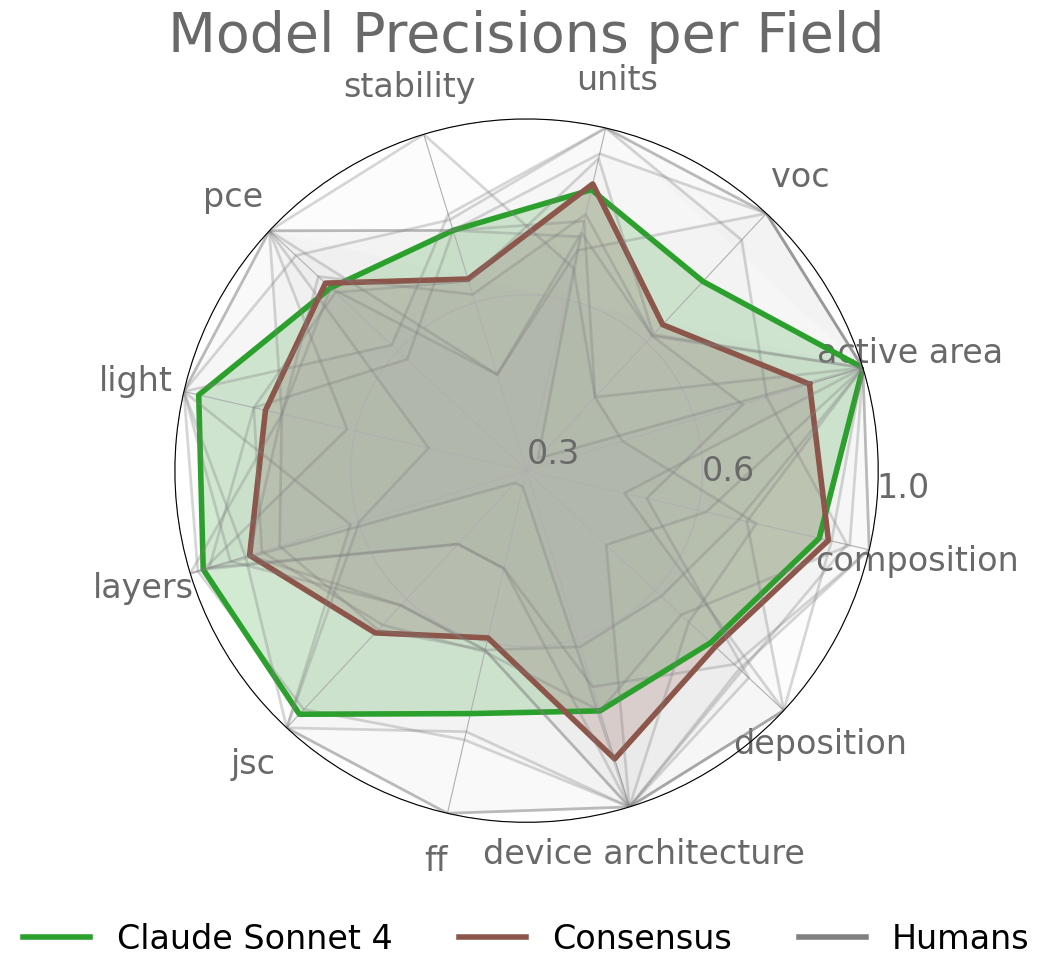

In [79]:
human_radar_precision_fig